# 14 — Germany vs USA Data Gap Analysis
**GridPulse** — Identifying mismatches, missing features, and alignment gaps between the Germany (OPSD) and USA (EIA-930) datasets for unified multi-country forecasting.

| Country | Source | Targets | Models Dir |
|---------|--------|---------|------------|
| Germany | OPSD 60-min | load, wind, solar, price | `artifacts/models/` |
| USA | EIA-930 MISO | load, wind, solar | `artifacts/models_eia930/` |

## 1. Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os, pickle, warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.1)

ROOT = Path("..").resolve()
DE_PARQUET = ROOT / "data" / "processed" / "features.parquet"
US_PARQUET = ROOT / "data" / "processed" / "us_eia930" / "features.parquet"
DE_MODELS  = ROOT / "artifacts" / "models"
US_MODELS  = ROOT / "artifacts" / "models_eia930"

print(f"Project root : {ROOT}")
print(f"DE parquet    : {DE_PARQUET}  exists={DE_PARQUET.exists()}")
print(f"US parquet    : {US_PARQUET}  exists={US_PARQUET.exists()}")
print(f"DE models dir : {DE_MODELS}  exists={DE_MODELS.exists()}")
print(f"US models dir : {US_MODELS}  exists={US_MODELS.exists()}")

Project root : /Users/pratik_n/Downloads/gridpulse
DE parquet    : /Users/pratik_n/Downloads/gridpulse/data/processed/features.parquet  exists=True
US parquet    : /Users/pratik_n/Downloads/gridpulse/data/processed/us_eia930/features.parquet  exists=True
DE models dir : /Users/pratik_n/Downloads/gridpulse/artifacts/models  exists=True
US models dir : /Users/pratik_n/Downloads/gridpulse/artifacts/models_eia930  exists=True


## 2. Load Germany and USA Datasets

In [4]:
df_de = pd.read_parquet(DE_PARQUET)
df_us = pd.read_parquet(US_PARQUET)

# Ensure timestamp is the index for both
for df, label in [(df_de, "DE"), (df_us, "US")]:
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df.set_index("timestamp", inplace=True)

print(f"Germany  : {df_de.shape[0]:,} rows × {df_de.shape[1]} cols  |  {df_de.index.min()} → {df_de.index.max()}")
print(f"USA      : {df_us.shape[0]:,} rows × {df_us.shape[1]} cols  |  {df_us.index.min()} → {df_us.index.max()}")
print(f"\nGermany columns:\n  {sorted(df_de.columns.tolist())}")
print(f"\nUSA columns:\n  {sorted(df_us.columns.tolist())}")

Germany  : 17,377 rows × 97 cols  |  2018-10-07 23:00:00+00:00 → 2020-09-30 23:00:00+00:00
USA      : 92,382 rows × 38 cols  |  2015-07-08 06:00:00+00:00 → 2026-01-20 11:00:00+00:00

Germany columns:
  ['carbon_kg_per_mwh', 'carbon_kg_per_mwh_lag_1', 'carbon_kg_per_mwh_lag_168', 'carbon_kg_per_mwh_lag_24', 'carbon_kg_per_mwh_roll_mean_168', 'carbon_kg_per_mwh_roll_mean_24', 'carbon_kg_per_mwh_roll_std_168', 'carbon_kg_per_mwh_roll_std_24', 'dayofweek', 'hour', 'is_daylight', 'is_evening_peak', 'is_holiday', 'is_morning_peak', 'is_post_holiday', 'is_pre_holiday', 'is_weekend', 'load_mw', 'load_mw_delta_1h', 'load_mw_delta_24h', 'load_mw_lag_1', 'load_mw_lag_168', 'load_mw_lag_24', 'load_mw_roll_mean_168', 'load_mw_roll_mean_24', 'load_mw_roll_std_168', 'load_mw_roll_std_24', 'month', 'price_eur_mwh', 'price_eur_mwh_lag_1', 'price_eur_mwh_lag_168', 'price_eur_mwh_lag_24', 'price_eur_mwh_roll_mean_168', 'price_eur_mwh_roll_mean_24', 'price_eur_mwh_roll_std_168', 'price_eur_mwh_roll_std_24

## 3. Initial Data Exploration & Shape Comparison

In [5]:
# Side-by-side shape comparison
summary = pd.DataFrame({
    "Metric": ["Rows", "Columns", "Start Date", "End Date", "Duration (days)",
               "Hourly Freq?", "Memory (MB)"],
    "Germany (OPSD)": [
        f"{df_de.shape[0]:,}", df_de.shape[1],
        str(df_de.index.min())[:10], str(df_de.index.max())[:10],
        (df_de.index.max() - df_de.index.min()).days,
        str(pd.infer_freq(df_de.index[:500])),
        f"{df_de.memory_usage(deep=True).sum() / 1e6:.1f}",
    ],
    "USA (EIA-930)": [
        f"{df_us.shape[0]:,}", df_us.shape[1],
        str(df_us.index.min())[:10], str(df_us.index.max())[:10],
        (df_us.index.max() - df_us.index.min()).days,
        str(pd.infer_freq(df_us.index[:500])),
        f"{df_us.memory_usage(deep=True).sum() / 1e6:.1f}",
    ],
})
display(summary.style.set_caption("Dataset Overview").hide(axis="index"))

print("\n--- Germany describe() ---")
display(df_de[["load_mw", "wind_mw", "solar_mw"]].describe().round(1))
print("\n--- USA describe() ---")
display(df_us[["load_mw", "wind_mw", "solar_mw"]].describe().round(1))

Metric,Germany (OPSD),USA (EIA-930)
Rows,"17,377","92,382"
Columns,97,38
Start Date,2018-10-07,2015-07-08
End Date,2020-09-30,2026-01-20
Duration (days),724,3849
Hourly Freq?,h,h
Memory (MB),13.4,27.7



--- Germany describe() ---


,load_mw,wind_mw,solar_mw
count,17377.0,17377.0,17377.0
mean,55156.4,14369.0,5013.2
std,9998.1,10321.6,7665.9
min,31923.0,136.0,0.0
25%,47009.0,6161.0,0.0
50%,54752.0,11728.0,156.0
75%,63448.0,20375.0,7995.0
max,76925.0,46064.0,32947.0



--- USA describe() ---


,load_mw,wind_mw,solar_mw
count,92382.0,92382.0,92382.0
mean,74095.3,1617.4,424.5
std,11573.5,4526.9,1794.4
min,48878.0,0.0,0.0
25%,65951.0,0.0,0.0
50%,72248.5,0.0,0.0
75%,79941.0,0.0,0.0
max,120781.0,26132.0,14315.0


## 4. Identify Missing Values in Both Datasets

In [6]:
# Missing values per column in both datasets
de_miss = df_de.isnull().sum().rename("DE_missing")
us_miss = df_us.isnull().sum().rename("US_missing")

# Also check for zeros (important for solar/wind — could be real or missing)
de_zeros = (df_de == 0).sum().rename("DE_zeros")
us_zeros = (df_us == 0).sum().rename("US_zeros")

# Combine into comparison table
all_cols = sorted(set(df_de.columns) | set(df_us.columns))
miss_df = pd.DataFrame(index=all_cols)
miss_df["In_DE"] = [c in df_de.columns for c in all_cols]
miss_df["In_US"] = [c in df_us.columns for c in all_cols]
miss_df["DE_NaN"] = [df_de[c].isnull().sum() if c in df_de.columns else "—" for c in all_cols]
miss_df["US_NaN"] = [df_us[c].isnull().sum() if c in df_us.columns else "—" for c in all_cols]
miss_df["DE_zeros"] = [int((df_de[c] == 0).sum()) if c in df_de.columns and df_de[c].dtype != object else "—" for c in all_cols]
miss_df["US_zeros"] = [int((df_us[c] == 0).sum()) if c in df_us.columns and df_us[c].dtype != object else "—" for c in all_cols]

print(f"Total NaN in Germany: {df_de.isnull().sum().sum()}")
print(f"Total NaN in USA    : {df_us.isnull().sum().sum()}")
print(f"\nColumns with NaN in DE: {(df_de.isnull().sum() > 0).sum()}")
print(f"Columns with NaN in US: {(df_us.isnull().sum() > 0).sum()}")

# Show columns that exist in only one dataset
only_de = [c for c in all_cols if c in df_de.columns and c not in df_us.columns]
only_us = [c for c in all_cols if c in df_us.columns and c not in df_de.columns]
print(f"\n⚠️  Columns ONLY in Germany ({len(only_de)}): {only_de}")
print(f"⚠️  Columns ONLY in USA ({len(only_us)}): {only_us}")

display(miss_df)

Total NaN in Germany: 0
Total NaN in USA    : 0

Columns with NaN in DE: 0
Columns with NaN in US: 0

⚠️  Columns ONLY in Germany (59): ['carbon_kg_per_mwh', 'carbon_kg_per_mwh_lag_1', 'carbon_kg_per_mwh_lag_168', 'carbon_kg_per_mwh_lag_24', 'carbon_kg_per_mwh_roll_mean_168', 'carbon_kg_per_mwh_roll_mean_24', 'carbon_kg_per_mwh_roll_std_168', 'carbon_kg_per_mwh_roll_std_24', 'is_holiday', 'is_post_holiday', 'is_pre_holiday', 'price_eur_mwh', 'price_eur_mwh_lag_1', 'price_eur_mwh_lag_168', 'price_eur_mwh_lag_24', 'price_eur_mwh_roll_mean_168', 'price_eur_mwh_roll_mean_24', 'price_eur_mwh_roll_std_168', 'price_eur_mwh_roll_std_24', 'wx_cloud_cover', 'wx_cloud_cover_lag_1', 'wx_cloud_cover_lag_168', 'wx_cloud_cover_lag_24', 'wx_cloud_cover_roll_mean_168', 'wx_cloud_cover_roll_mean_24', 'wx_cloud_cover_roll_std_168', 'wx_cloud_cover_roll_std_24', 'wx_precipitation', 'wx_precipitation_lag_1', 'wx_precipitation_lag_168', 'wx_precipitation_lag_24', 'wx_precipitation_roll_mean_168', 'wx_precip

,In_DE,In_US,DE_NaN,US_NaN,DE_zeros,US_zeros
carbon_kg_per_mwh,True,False,0,—,0,—
carbon_kg_per_mwh_lag_1,True,False,0,—,0,—
carbon_kg_per_mwh_lag_168,True,False,0,—,0,—
carbon_kg_per_mwh_lag_24,True,False,0,—,0,—
carbon_kg_per_mwh_roll_mean_168,True,False,0,—,0,—
...,...,...,...,...,...,...
wx_wind_speed_10m_lag_24,True,False,0,—,1,—
wx_wind_speed_10m_roll_mean_168,True,False,0,—,0,—
wx_wind_speed_10m_roll_mean_24,True,False,0,—,0,—
wx_wind_speed_10m_roll_std_168,True,False,0,—,0,—


## 5. Visualize Missing Data Patterns & Zero-Dominated Columns

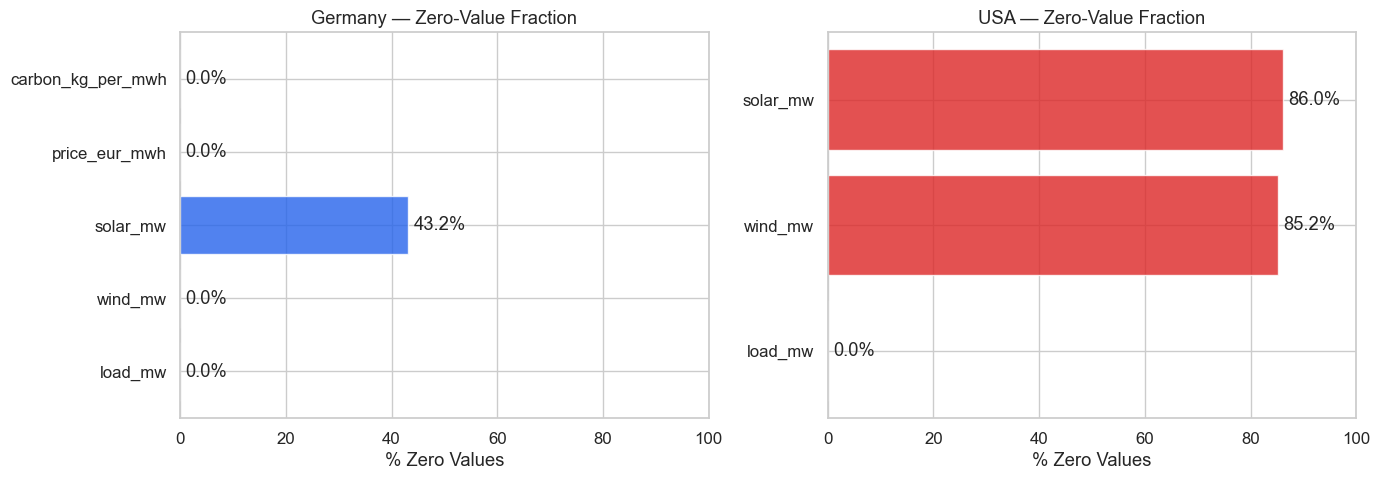

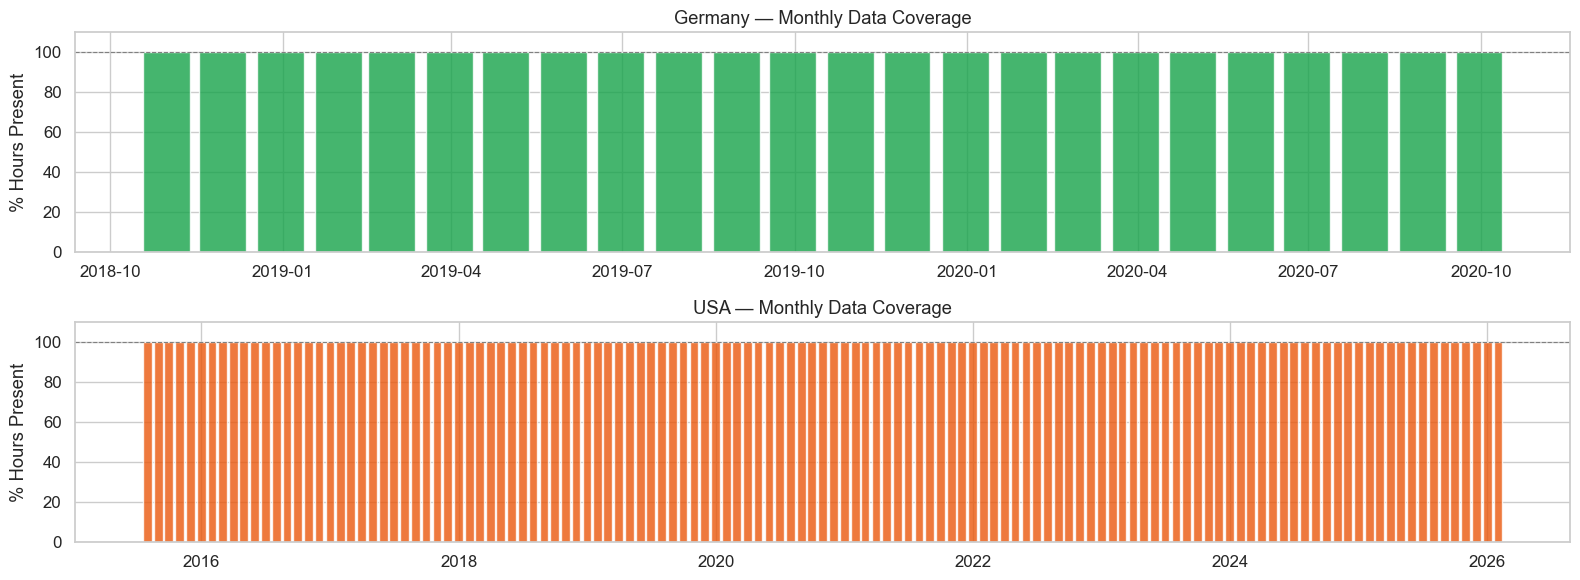

In [7]:
# Zero-fraction analysis for core targets (solar/wind often report 0 at night)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, df, label, color in zip(axes, [df_de, df_us], ["Germany", "USA"], ["#2563eb", "#dc2626"]):
    targets = [c for c in ["load_mw", "wind_mw", "solar_mw", "price_eur_mwh", "carbon_kg_per_mwh"] if c in df.columns]
    zero_pct = [(df[c] == 0).mean() * 100 for c in targets]
    bars = ax.barh(targets, zero_pct, color=color, alpha=0.8)
    ax.set_xlabel("% Zero Values")
    ax.set_title(f"{label} — Zero-Value Fraction")
    ax.set_xlim(0, 100)
    for bar, pct in zip(bars, zero_pct):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f"{pct:.1f}%", va="center")

plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_zero_fraction.png", dpi=150, bbox_inches="tight")
plt.show()

# Time-series coverage heatmap (monthly data availability)
fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=False)
for ax, df, label in zip(axes, [df_de, df_us], ["Germany", "USA"]):
    monthly = df[["load_mw"]].resample("M").count()
    expected_hours = df.index.to_series().resample("M").apply(lambda x: len(pd.date_range(x.min(), x.max(), freq="h")))
    coverage = (monthly["load_mw"] / expected_hours.clip(lower=1) * 100).fillna(0)
    ax.bar(coverage.index, coverage.values, width=25, color="#16a34a" if label == "Germany" else "#ea580c", alpha=0.8)
    ax.set_ylabel("% Hours Present")
    ax.set_title(f"{label} — Monthly Data Coverage")
    ax.axhline(100, color="gray", ls="--", lw=0.8)
    ax.set_ylim(0, 110)

plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_monthly_coverage.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Column Mismatch Analysis — Germany vs USA Features

✅ Common columns       : 38
🇩🇪 Germany-only columns : 59
🇺🇸 USA-only columns     : 0

GERMANY-ONLY COLUMNS BY CATEGORY

  Price (8 cols):
    • price_eur_mwh
    • price_eur_mwh_lag_1
    • price_eur_mwh_lag_168
    • price_eur_mwh_lag_24
    • price_eur_mwh_roll_mean_168
    • price_eur_mwh_roll_mean_24
    • price_eur_mwh_roll_std_168
    • price_eur_mwh_roll_std_24

  Carbon (8 cols):
    • carbon_kg_per_mwh
    • carbon_kg_per_mwh_lag_1
    • carbon_kg_per_mwh_lag_168
    • carbon_kg_per_mwh_lag_24
    • carbon_kg_per_mwh_roll_mean_168
    • carbon_kg_per_mwh_roll_mean_24
    • carbon_kg_per_mwh_roll_std_168
    • carbon_kg_per_mwh_roll_std_24

  Weather (40 cols):
    • wx_cloud_cover
    • wx_cloud_cover_lag_1
    • wx_cloud_cover_lag_168
    • wx_cloud_cover_lag_24
    • wx_cloud_cover_roll_mean_168
    • wx_cloud_cover_roll_mean_24
    • wx_cloud_cover_roll_std_168
    • wx_cloud_cover_roll_std_24
    • wx_precipitation
    • wx_precipitation_lag_1
    • wx_precipitation_lag_16

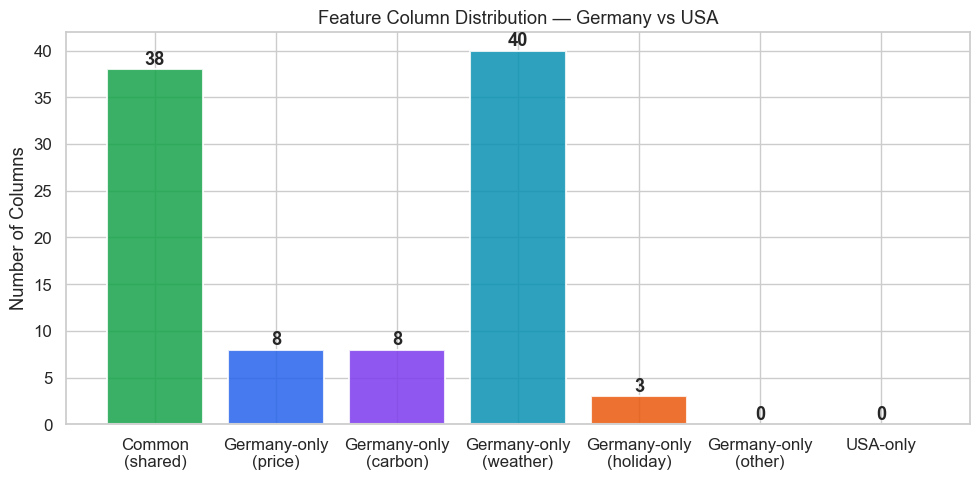

In [8]:
de_cols = set(df_de.columns)
us_cols = set(df_us.columns)
common   = sorted(de_cols & us_cols)
only_de  = sorted(de_cols - us_cols)
only_us  = sorted(us_cols - de_cols)

print(f"✅ Common columns       : {len(common)}")
print(f"🇩🇪 Germany-only columns : {len(only_de)}")
print(f"🇺🇸 USA-only columns     : {len(only_us)}")

# Categorize the Germany-only columns
categories = {
    "Price": [c for c in only_de if "price" in c],
    "Carbon": [c for c in only_de if "carbon" in c],
    "Weather": [c for c in only_de if c.startswith("wx_")],
    "Holiday": [c for c in only_de if "holiday" in c],
    "Other": [],
}
categorized = set()
for v in categories.values():
    categorized.update(v)
categories["Other"] = [c for c in only_de if c not in categorized]

print(f"\n{'='*60}")
print(f"GERMANY-ONLY COLUMNS BY CATEGORY")
print(f"{'='*60}")
for cat, cols in categories.items():
    if cols:
        print(f"\n  {cat} ({len(cols)} cols):")
        for c in cols:
            print(f"    • {c}")

# Visual column Venn
fig, ax = plt.subplots(figsize=(10, 5))
bar_data = pd.DataFrame({
    "Category": ["Common\n(shared)", "Germany-only\n(price)", "Germany-only\n(carbon)",
                 "Germany-only\n(weather)", "Germany-only\n(holiday)", "Germany-only\n(other)", "USA-only"],
    "Count": [len(common), len(categories["Price"]), len(categories["Carbon"]),
              len(categories["Weather"]), len(categories["Holiday"]), len(categories["Other"]), len(only_us)],
    "Color": ["#16a34a", "#2563eb", "#7c3aed", "#0891b2", "#ea580c", "#6b7280", "#dc2626"]
})
bars = ax.bar(bar_data["Category"], bar_data["Count"], color=bar_data["Color"], alpha=0.85, edgecolor="white", linewidth=1.5)
for bar, count in zip(bars, bar_data["Count"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), ha="center", fontweight="bold")
ax.set_ylabel("Number of Columns")
ax.set_title("Feature Column Distribution — Germany vs USA")
plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_column_venn.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Data Type & Schema Differences

In [9]:
# Compare data types for common columns
dtype_cmp = pd.DataFrame({
    "Column": common,
    "DE_dtype": [str(df_de[c].dtype) for c in common],
    "US_dtype": [str(df_us[c].dtype) for c in common],
})
dtype_cmp["Match"] = dtype_cmp["DE_dtype"] == dtype_cmp["US_dtype"]
mismatches = dtype_cmp[~dtype_cmp["Match"]]

if len(mismatches) == 0:
    print("✅ All common columns have matching data types")
else:
    print(f"⚠️  {len(mismatches)} columns have type mismatches:")
    display(mismatches)

display(dtype_cmp.style.set_caption("Schema Comparison for Common Columns")
        .applymap(lambda v: "background-color: #fecaca" if v == False else "", subset=["Match"]))

✅ All common columns have matching data types


,Column,DE_dtype,US_dtype,Match
0,dayofweek,int32,int32,True
1,hour,int32,int32,True
2,is_daylight,int64,int64,True
3,is_evening_peak,int64,int64,True
4,is_morning_peak,int64,int64,True
5,is_weekend,int64,int64,True
6,load_mw,float64,float64,True
7,load_mw_delta_1h,float64,float64,True
8,load_mw_delta_24h,float64,float64,True
9,load_mw_lag_1,float64,float64,True


## 8. Value Range & Distribution Comparison (Common Targets)

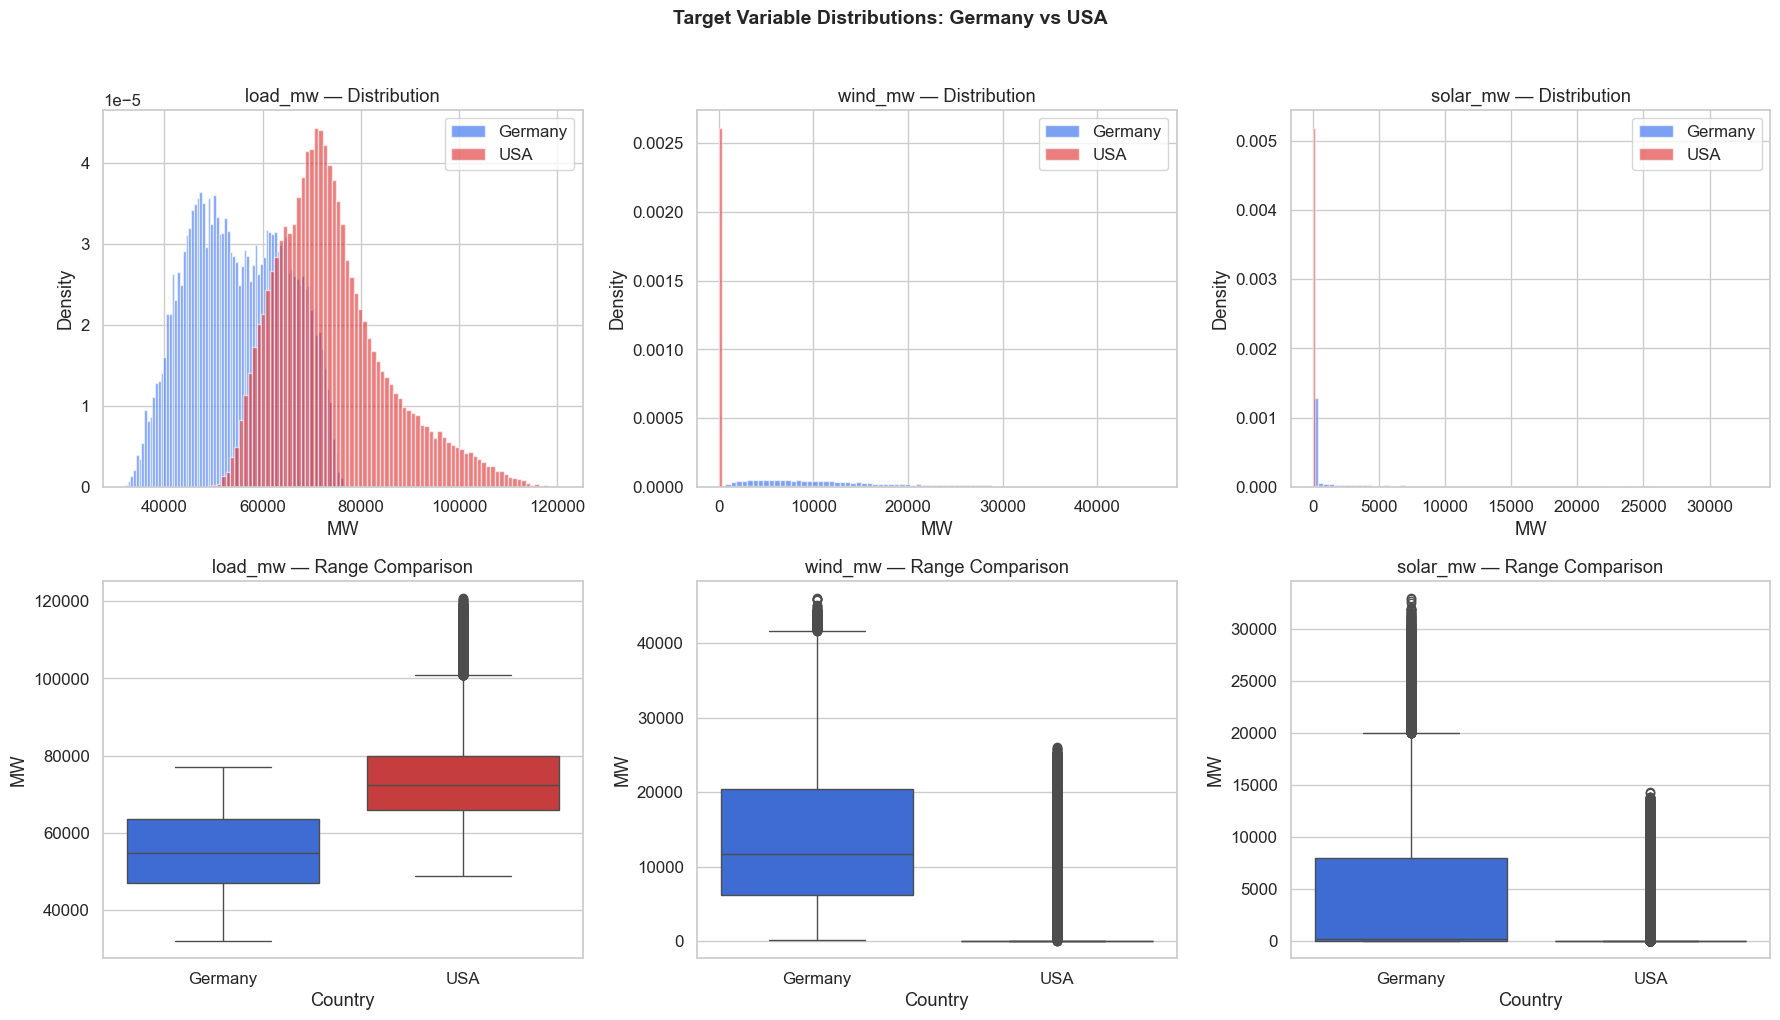

,Target,DE_min,DE_max,DE_mean,DE_std,US_min,US_max,US_mean,US_std,Scale_ratio
0,load_mw,31923.000000,76925.000000,55156.400000,9998.100000,48878.000000,120781.000000,74095.300000,11573.500000,1.300000
1,wind_mw,136.000000,46064.000000,14369.000000,10321.600000,0.000000,26132.000000,1617.400000,4526.900000,0.100000
2,solar_mw,0.000000,32947.000000,5013.200000,7665.900000,0.000000,14315.000000,424.500000,1794.400000,0.100000


In [10]:
# Side-by-side distributions for the 3 common targets
targets = ["load_mw", "wind_mw", "solar_mw"]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Histograms
for i, col in enumerate(targets):
    ax = axes[0, i]
    ax.hist(df_de[col].dropna(), bins=80, alpha=0.6, color="#2563eb", label="Germany", density=True)
    ax.hist(df_us[col].dropna(), bins=80, alpha=0.6, color="#dc2626", label="USA", density=True)
    ax.set_title(f"{col} — Distribution")
    ax.set_xlabel("MW")
    ax.set_ylabel("Density")
    ax.legend()

# Row 2: Box plots
for i, col in enumerate(targets):
    ax = axes[1, i]
    box_data = pd.DataFrame({
        "Value": pd.concat([df_de[col], df_us[col]], ignore_index=True),
        "Country": ["Germany"] * len(df_de) + ["USA"] * len(df_us),
    })
    sns.boxplot(data=box_data, x="Country", y="Value", ax=ax, palette={"Germany": "#2563eb", "USA": "#dc2626"})
    ax.set_title(f"{col} — Range Comparison")
    ax.set_ylabel("MW")

plt.suptitle("Target Variable Distributions: Germany vs USA", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_distribution_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# Numeric comparison table
range_cmp = []
for col in targets:
    range_cmp.append({
        "Target": col,
        "DE_min": df_de[col].min(), "DE_max": df_de[col].max(),
        "DE_mean": df_de[col].mean(), "DE_std": df_de[col].std(),
        "US_min": df_us[col].min(), "US_max": df_us[col].max(),
        "US_mean": df_us[col].mean(), "US_std": df_us[col].std(),
        "Scale_ratio": df_us[col].mean() / df_de[col].mean() if df_de[col].mean() != 0 else np.nan,
    })
range_df = pd.DataFrame(range_cmp)
display(range_df.round(1).style.set_caption("Value Range Comparison"))

## 9. Model Size Comparison & Training Quality Check

,Country,Model,Size_KB,Size_MB,Modified
0,Germany,gbm_lightgbm_load_mw.pkl,10456.620000,10.210000,2026-02-07 15:10
1,Germany,gbm_lightgbm_price_eur_mwh.pkl,11268.380000,11.000000,2026-02-07 16:07
2,Germany,gbm_lightgbm_solar_mw.pkl,9356.490000,9.140000,2026-02-07 15:41
3,Germany,gbm_lightgbm_wind_mw.pkl,8232.130000,8.040000,2026-02-07 15:09
4,Germany,lstm_load_mw.pt,982.830000,0.960000,2026-02-07 15:22
5,Germany,lstm_price_eur_mwh.pt,982.930000,0.960000,2026-02-07 16:15
6,Germany,lstm_solar_mw.pt,982.850000,0.960000,2026-02-07 15:49
7,Germany,lstm_wind_mw.pt,982.830000,0.960000,2026-02-07 15:20
8,Germany,tcn_load_mw.pt,353.140000,0.340000,2026-02-07 15:07
9,Germany,tcn_price_eur_mwh.pt,353.310000,0.350000,2026-02-07 16:30


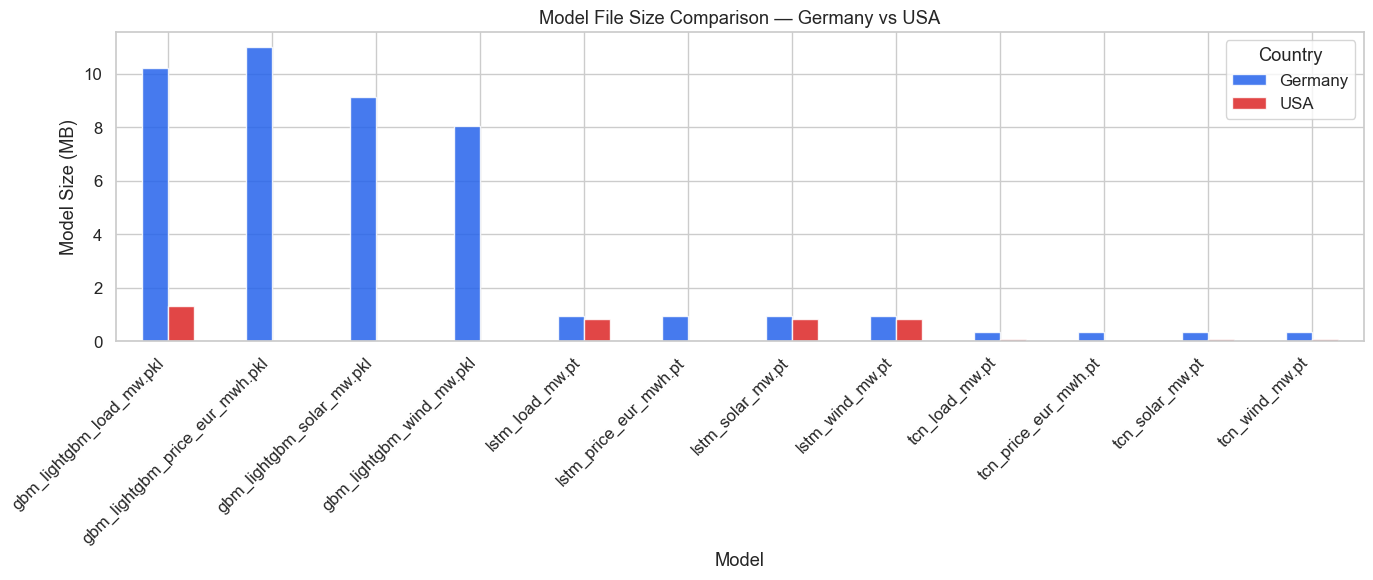


🚨 SUSPICIOUS MODELS (< 50 KB — likely degenerate):
   USA / gbm_lightgbm_solar_mw.pkl → 5.9 KB
   USA / gbm_lightgbm_wind_mw.pkl → 5.9 KB
   These models likely learned near-constant predictions due to data quality issues.


In [11]:
# Compare model file sizes between DE and US
model_rows = []
for model_dir, country in [(DE_MODELS, "Germany"), (US_MODELS, "USA")]:
    if model_dir.exists():
        for f in sorted(model_dir.iterdir()):
            if f.suffix in (".pkl", ".pt") and not f.name.startswith("."):
                model_rows.append({
                    "Country": country,
                    "Model": f.name,
                    "Size_KB": f.stat().st_size / 1024,
                    "Size_MB": f.stat().st_size / (1024 * 1024),
                    "Modified": pd.Timestamp.fromtimestamp(f.stat().st_mtime).strftime("%Y-%m-%d %H:%M"),
                })

model_df = pd.DataFrame(model_rows)
display(model_df.round(2).style.set_caption("Model Artifact Comparison")
        .applymap(lambda v: "background-color: #fecaca; font-weight: bold" if isinstance(v, (int, float)) and v < 0.01 else "", subset=["Size_MB"]))

# Side-by-side model size bar chart
fig, ax = plt.subplots(figsize=(14, 6))
pivot = model_df.pivot(index="Model", columns="Country", values="Size_MB").fillna(0)
pivot.plot(kind="bar", ax=ax, color={"Germany": "#2563eb", "USA": "#dc2626"}, alpha=0.85, edgecolor="white")
ax.set_ylabel("Model Size (MB)")
ax.set_title("Model File Size Comparison — Germany vs USA")
ax.legend(title="Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_model_sizes.png", dpi=150, bbox_inches="tight")
plt.show()

# Flag suspicious models
suspicious = model_df[model_df["Size_KB"] < 50]
if len(suspicious) > 0:
    print(f"\n🚨 SUSPICIOUS MODELS (< 50 KB — likely degenerate):")
    for _, row in suspicious.iterrows():
        print(f"   {row['Country']} / {row['Model']} → {row['Size_KB']:.1f} KB")
    print("   These models likely learned near-constant predictions due to data quality issues.")

## 10. Temporal Alignment — Seasonal & Hourly Patterns

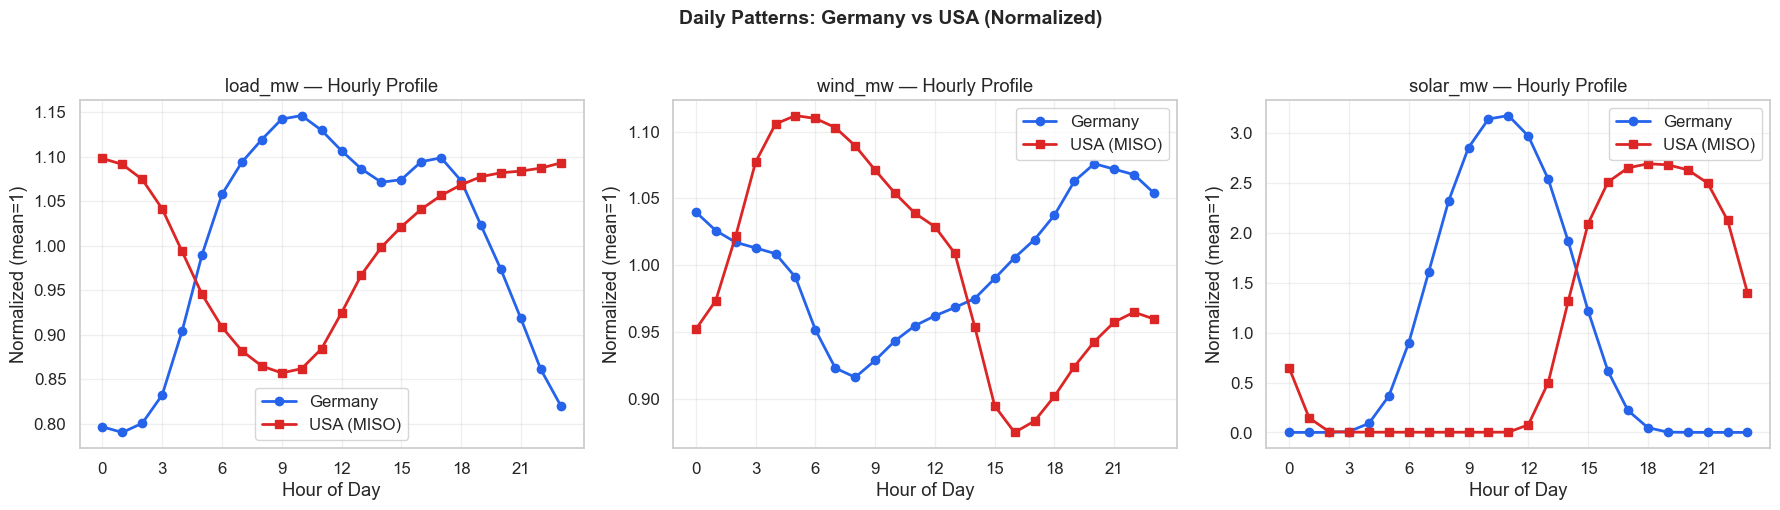

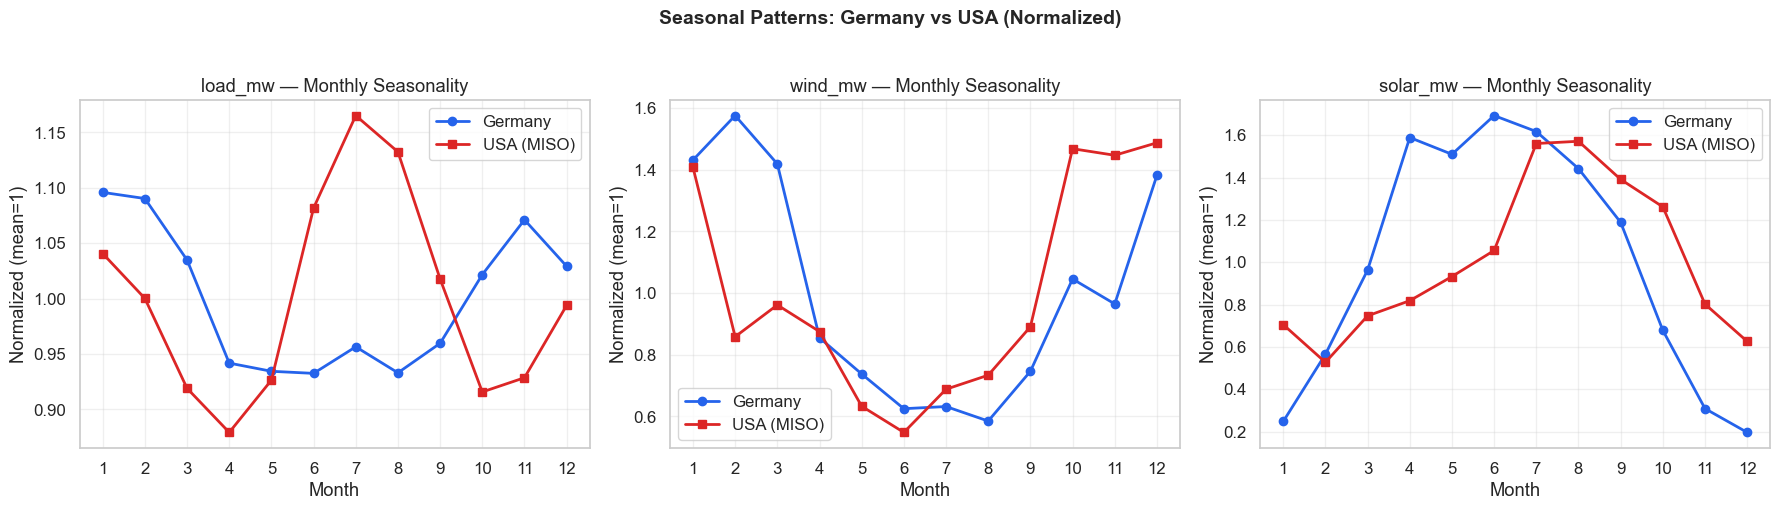

In [12]:
# Hourly load profiles (normalized) — do the daily shapes match?
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(["load_mw", "wind_mw", "solar_mw"]):
    ax = axes[i]
    # Normalize by mean to compare shapes not magnitudes
    de_hourly = df_de.groupby(df_de.index.hour)[col].mean()
    us_hourly = df_us.groupby(df_us.index.hour)[col].mean()
    de_norm = de_hourly / de_hourly.mean()
    us_norm = us_hourly / us_hourly.mean()

    ax.plot(de_norm.index, de_norm.values, "o-", color="#2563eb", label="Germany", linewidth=2)
    ax.plot(us_norm.index, us_norm.values, "s-", color="#dc2626", label="USA (MISO)", linewidth=2)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Normalized (mean=1)")
    ax.set_title(f"{col} — Hourly Profile")
    ax.legend()
    ax.set_xticks(range(0, 24, 3))
    ax.grid(True, alpha=0.3)

plt.suptitle("Daily Patterns: Germany vs USA (Normalized)", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_hourly_profiles.png", dpi=150, bbox_inches="tight")
plt.show()

# Monthly seasonality
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(["load_mw", "wind_mw", "solar_mw"]):
    ax = axes[i]
    de_monthly = df_de.groupby(df_de.index.month)[col].mean()
    us_monthly = df_us.groupby(df_us.index.month)[col].mean()
    de_norm = de_monthly / de_monthly.mean()
    us_norm = us_monthly / us_monthly.mean()

    ax.plot(de_norm.index, de_norm.values, "o-", color="#2563eb", label="Germany", linewidth=2)
    ax.plot(us_norm.index, us_norm.values, "s-", color="#dc2626", label="USA (MISO)", linewidth=2)
    ax.set_xlabel("Month")
    ax.set_ylabel("Normalized (mean=1)")
    ax.set_title(f"{col} — Monthly Seasonality")
    ax.legend()
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

plt.suptitle("Seasonal Patterns: Germany vs USA (Normalized)", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_seasonal_profiles.png", dpi=150, bbox_inches="tight")
plt.show()

## 11. Feature Correlation — Common Features Across Countries

Feature correlations with load_mw — largest differences between countries:


,DE_corr,US_corr,Diff
is_morning_peak,0.309000,-0.383000,0.692000
solar_mw_roll_mean_168,-0.325000,0.079000,0.404000
solar_mw_roll_mean_24,-0.303000,0.083000,0.386000
solar_mw_roll_std_168,-0.315000,0.064000,0.380000
solar_mw_roll_std_24,-0.285000,0.072000,0.357000
is_daylight,0.402000,0.065000,0.337000
load_mw_roll_std_168,0.202000,0.499000,0.296000
is_weekend,-0.468000,-0.202000,0.266000
dayofweek,-0.386000,-0.151000,0.235000
wind_mw_roll_mean_168,0.230000,0.011000,0.220000


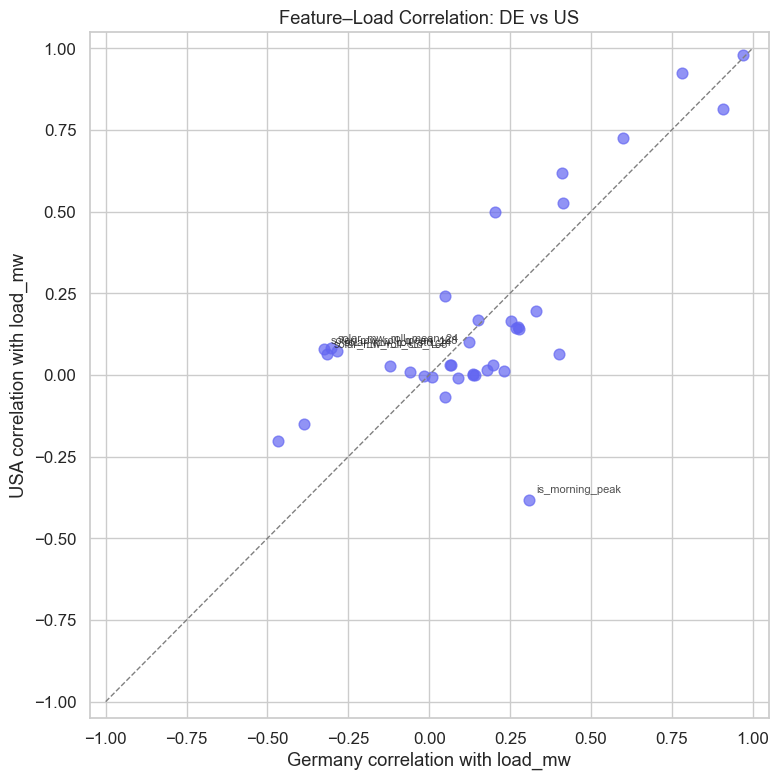

In [13]:
# Correlations with load_mw for common numeric features
numeric_common = [c for c in common if df_de[c].dtype in (np.float64, np.int64, np.float32, np.int32)]
de_corr = df_de[numeric_common].corr()["load_mw"].drop("load_mw").sort_values(ascending=False)
us_corr = df_us[numeric_common].corr()["load_mw"].drop("load_mw").sort_values(ascending=False)

corr_cmp = pd.DataFrame({"DE_corr": de_corr, "US_corr": us_corr}).dropna()
corr_cmp["Diff"] = (corr_cmp["DE_corr"] - corr_cmp["US_corr"]).abs()
corr_cmp = corr_cmp.sort_values("Diff", ascending=False)

print("Feature correlations with load_mw — largest differences between countries:")
display(corr_cmp.head(15).round(3).style
        .set_caption("Correlation with load_mw")
        .background_gradient(subset=["Diff"], cmap="YlOrRd"))

# Scatter plot of correlations
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(corr_cmp["DE_corr"], corr_cmp["US_corr"], alpha=0.7, s=60, color="#6366f1")
ax.plot([-1, 1], [-1, 1], "--", color="gray", lw=1)
ax.set_xlabel("Germany correlation with load_mw")
ax.set_ylabel("USA correlation with load_mw")
ax.set_title("Feature–Load Correlation: DE vs US")
# Label top outliers
for feat in corr_cmp.head(5).index:
    ax.annotate(feat, (corr_cmp.loc[feat, "DE_corr"], corr_cmp.loc[feat, "US_corr"]),
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords="offset points")
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
plt.tight_layout()
plt.savefig(ROOT / "reports" / "figures" / "gap_correlation_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

## 12. Final Gap Analysis Summary & Prediction Readiness

In [14]:
# ── COMPREHENSIVE GAP ANALYSIS REPORT ──
print("=" * 70)
print("  GRIDPULSE — GERMANY vs USA GAP ANALYSIS REPORT")
print("=" * 70)

# 1. Training status
de_model_count = len([f for f in DE_MODELS.iterdir() if f.suffix in (".pkl", ".pt")])
us_model_count = len([f for f in US_MODELS.iterdir() if f.suffix in (".pkl", ".pt")])
print(f"\n📊 TRAINING STATUS")
print(f"   Germany : {de_model_count} models (4 targets × 3 architectures = 12)")
print(f"   USA     : {us_model_count} models (3 targets × 3 architectures = 9)")
us_suspicious = [f.name for f in US_MODELS.iterdir() if f.suffix in (".pkl", ".pt") and f.stat().st_size < 50_000]
if us_suspicious:
    print(f"   ⚠️  DEGENERATE US MODELS (< 50 KB): {us_suspicious}")

# 2. Feature gap
print(f"\n📋 FEATURE GAP")
print(f"   Germany features : {df_de.shape[1]} columns")
print(f"   USA features     : {df_us.shape[1]} columns")
print(f"   Common features  : {len(common)} columns")
print(f"   Missing in USA   : {len(only_de)} columns")
gap_cats = {
    "Weather (wx_*)": len([c for c in only_de if c.startswith("wx_")]),
    "Price/carbon": len([c for c in only_de if "price" in c or "carbon" in c]),
    "Holiday": len([c for c in only_de if "holiday" in c]),
}
for cat, count in gap_cats.items():
    print(f"     • {cat}: {count} features missing")

# 3. Target gap
print(f"\n🎯 TARGET VARIABLE GAP")
de_targets = [c for c in ["load_mw", "wind_mw", "solar_mw", "price_eur_mwh"] if c in df_de.columns]
us_targets = [c for c in ["load_mw", "wind_mw", "solar_mw", "price_usd_mwh"] if c in df_us.columns]
print(f"   Germany targets: {de_targets}")
print(f"   USA targets    : {us_targets}")
if "price_eur_mwh" in df_de.columns and "price_usd_mwh" not in df_us.columns:
    print(f"   ❌ USA missing price target — EIA-930 has no LMP data")

# 4. Scale differences
print(f"\n📏 SCALE DIFFERENCES (mean values)")
for col in ["load_mw", "wind_mw", "solar_mw"]:
    de_mean = df_de[col].mean()
    us_mean = df_us[col].mean()
    ratio = us_mean / de_mean if de_mean != 0 else float("inf")
    print(f"   {col:12s}  DE={de_mean:>10,.1f}  US={us_mean:>10,.1f}  ratio={ratio:.2f}x")

# 5. Data quality
print(f"\n✅ DATA QUALITY")
print(f"   Germany NaN total    : {df_de.isnull().sum().sum()}")
print(f"   USA NaN total        : {df_us.isnull().sum().sum()}")
us_solar_zero_pct = (df_us["solar_mw"] == 0).mean() * 100
us_wind_zero_pct = (df_us["wind_mw"] == 0).mean() * 100
print(f"   USA solar zero%      : {us_solar_zero_pct:.1f}%")
print(f"   USA wind zero%       : {us_wind_zero_pct:.1f}%")
if us_solar_zero_pct > 60:
    print(f"   ⚠️  USA solar has {us_solar_zero_pct:.0f}% zeros — may explain degenerate GBM solar model")

# 6. Recommendations
print(f"\n{'='*70}")
print(f"  RECOMMENDATIONS")
print(f"{'='*70}")
recs = [
    "1. REBUILD USA features parquet — run build_features_eia930.py to add\n"
    "   price_usd_mwh proxy and carbon_kg_per_mwh (code exists, parquet is stale)",
    "2. ADD WEATHER DATA for USA — Open-Meteo API for MISO region coords\n"
    "   (would add ~35 features matching Germany's wx_* columns)",
    "3. ADD US HOLIDAY features — use `holidays` library with country='US'\n"
    "   (Thanksgiving, July 4th significantly impact load patterns)",
    "4. RETRAIN USA GBM solar/wind — current models are degenerate (5.9 KB)\n"
    "   due to high zero-fraction in the training data region",
    "5. NAMESPACE artifact paths — add country prefix to backtest/calibration\n"
    "   files to prevent DE/US overwriting each other",
    "6. ADD COUNTRY-SPECIFIC optimizer config — US electricity prices are\n"
    "   ~$30-50/MWh vs EU ~€70/MWh; carbon intensity differs too",
    "7. CREATE UNIFIED SCHEMA — define a common feature interface so both\n"
    "   countries produce the same column set for cross-country models",
]
for r in recs:
    print(f"\n   {r}")

print(f"\n{'='*70}")
print(f"  PREDICTION READINESS")
print(f"{'='*70}")
print(f"   Germany : ✅ READY — 12/12 models, 95+ features, price target available")
print(f"   USA     : ⚠️  PARTIAL — 9/9 models exist but 2 are degenerate,")
print(f"             missing weather/holiday/price features, 39 vs 95 columns")
print(f"             Cross-country prediction IMPOSSIBLE (feature count mismatch)")
print(f"{'='*70}")

  GRIDPULSE — GERMANY vs USA GAP ANALYSIS REPORT

📊 TRAINING STATUS
   Germany : 12 models (4 targets × 3 architectures = 12)
   USA     : 9 models (3 targets × 3 architectures = 9)
   ⚠️  DEGENERATE US MODELS (< 50 KB): ['gbm_lightgbm_solar_mw.pkl', 'gbm_lightgbm_wind_mw.pkl']

📋 FEATURE GAP
   Germany features : 97 columns
   USA features     : 38 columns
   Common features  : 38 columns
   Missing in USA   : 59 columns
     • Weather (wx_*): 40 features missing
     • Price/carbon: 16 features missing
     • Holiday: 3 features missing

🎯 TARGET VARIABLE GAP
   Germany targets: ['load_mw', 'wind_mw', 'solar_mw', 'price_eur_mwh']
   USA targets    : ['load_mw', 'wind_mw', 'solar_mw']
   ❌ USA missing price target — EIA-930 has no LMP data

📏 SCALE DIFFERENCES (mean values)
   load_mw       DE=  55,156.4  US=  74,095.3  ratio=1.34x
   wind_mw       DE=  14,369.0  US=   1,617.4  ratio=0.11x
   solar_mw      DE=   5,013.2  US=     424.5  ratio=0.08x

✅ DATA QUALITY
   Germany NaN total 

---
## 13. Deep-Dive: What is the USA (EIA-930) Dataset?

### What is EIA-930?

**EIA** = **U.S. Energy Information Administration** — the principal agency of the U.S. Federal Statistical System responsible for collecting, analyzing, and disseminating energy information.

**EIA Form 930** (officially: _"Hourly and Daily Balancing Authority Operations Report"_) provides **hourly demand and generation statistics** by **balancing authority (BA)** across the contiguous United States. Published via the [EIA Grid Monitor](https://www.eia.gov/electricity/gridmonitor/).

| Attribute | Value |
|-----------|-------|
| **Full name** | EIA Form 930 — Hourly and Daily Balancing Authority Operations Report |
| **Provider** | U.S. Energy Information Administration |
| **URL** | https://www.eia.gov/electricity/gridmonitor/ |
| **Frequency** | Hourly |
| **Geographic** | All ~60+ U.S. balancing authorities |
| **Default BA** | **MISO** (Midcontinent Independent System Operator) |
| **License** | U.S. Government Works (Public Domain) |
| **Data host** | Zenodo via Catalyst Cooperative / PUDL (record 18366739) |

### What is MISO?

**MISO** = Midcontinent Independent System Operator, covering **15 U.S. states** across the Midwest and South: Arkansas, Illinois, Indiana, Iowa, Kentucky, Louisiana, Michigan, Minnesota, Mississippi, Missouri, Montana, North Dakota, South Dakota, Texas (partial), Wisconsin.

### What signals does EIA-930 provide?
- **Demand (MW)** — total electric load
- **Demand forecast (MW)** — day-ahead forecast by BA
- **Net generation by fuel**: Coal, Gas, Nuclear, Petroleum, Hydro, Pumped Storage, Solar, Wind, Other, Unknown, Battery Storage, Geothermal
- **Interchange (MW)** — power flows between BAs, including international (Canada/Mexico)
- **Regional sub-BA breakdowns** (since 2018)

### How is it different from Germany (OPSD)?

| Aspect | Germany (OPSD) | USA (EIA-930) |
|--------|---------------|---------------|
| **Source** | Open Power System Data (academic) | U.S. EIA (government) |
| **Coverage** | Single country (Germany) | Single BA (MISO, 15 states) |
| **Time span** | 2015–2020 (static CSV, no updates) | 2015–2026+ (actively updated) |
| **Rows** | 17,377 | 92,382 |
| **Real price** | ✅ Day-ahead (EUR/MWh) | ❌ No LMP data |
| **Weather** | ✅ Open-Meteo (Berlin) | ❌ Not integrated |
| **Holidays** | ✅ German calendar | ❌ Not integrated |
| **Carbon** | ✅ Real signals + proxy | ⚠️ Proxy only |
| **Fuel breakdown** | Limited | ✅ Full (9+ fuel types) |
| **Interchange** | Not available | ✅ BA-to-BA flows |

In [15]:
# ── USA Raw Data Inventory ──
import zipfile

raw_dir = ROOT / "data" / "raw" / "us_eia930"
extracted_dir = raw_dir / "extracted"

# Count ZIP archives
zips = sorted(raw_dir.glob("*.zip"))
print(f"📦 ZIP Archives: {len(zips)} files")
print(f"   Date range: {zips[0].name} → {zips[-1].name}")
total_zip_mb = sum(z.stat().st_size for z in zips) / 1e6
print(f"   Total ZIP size: {total_zip_mb:.0f} MB\n")

# Show all ZIPs with sizes
zip_info = pd.DataFrame([
    {"File": z.name, "Size_MB": z.stat().st_size / 1e6, "Half": z.stem.split("-")[1]}
    for z in zips
])
display(zip_info.round(1).style.set_caption("EIA-930 ZIP Archives"))

# Count extracted CSVs by type
if extracted_dir.exists():
    csvs = sorted(extracted_dir.glob("*.csv"))
    csv_types = {}
    for c in csvs:
        parts = c.stem.split("-")
        kind = parts[-1] if len(parts) >= 3 else "unknown"
        csv_types[kind] = csv_types.get(kind, 0) + 1
    
    print(f"\n📄 Extracted CSVs: {len(csvs)} files")
    for kind, count in sorted(csv_types.items()):
        print(f"   • {kind}: {count} files")
    
    total_csv_mb = sum(c.stat().st_size for c in csvs) / 1e6
    print(f"   Total CSV size: {total_csv_mb:.0f} MB")

📦 ZIP Archives: 22 files
   Date range: eia930-2015half2.zip → eia930-2026half1.zip
   Total ZIP size: 392 MB



,File,Size_MB,Half
0,eia930-2015half2.zip,15.300000,2015half2
1,eia930-2016half1.zip,15.000000,2016half1
2,eia930-2016half2.zip,15.300000,2016half2
3,eia930-2017half1.zip,15.000000,2017half1
4,eia930-2017half2.zip,15.300000,2017half2
5,eia930-2018half1.zip,15.000000,2018half1
6,eia930-2018half2.zip,20.000000,2018half2
7,eia930-2019half1.zip,19.800000,2019half1
8,eia930-2019half2.zip,20.300000,2019half2
9,eia930-2020half1.zip,19.700000,2020half1



📄 Extracted CSVs: 60 files
   • balance: 22 files
   • interchange: 22 files
   • subregion: 16 files
   Total CSV size: 3459 MB


In [16]:
# ── Peek at Raw EIA-930 CSV Schema (legacy vs new-format) ──
# Read first row from earliest and latest CSV to compare schemas

extracted_dir = ROOT / "data" / "raw" / "us_eia930" / "extracted"
if extracted_dir.exists():
    csvs = sorted(extracted_dir.glob("*.csv"))
    
    # Find a "balance" file (main data we use)
    balance_csvs = [c for c in csvs if "balance" in c.name.lower() or "Balance" in c.name]
    if not balance_csvs:
        balance_csvs = csvs  # fallback
    
    earliest = balance_csvs[0]
    latest   = balance_csvs[-1]
    
    print(f"📜 EARLIEST file: {earliest.name}")
    df_early = pd.read_csv(earliest, nrows=3)
    print(f"   Columns ({len(df_early.columns)}): {list(df_early.columns)}\n")
    
    print(f"📜 LATEST  file: {latest.name}")
    df_late = pd.read_csv(latest, nrows=3)
    print(f"   Columns ({len(df_late.columns)}): {list(df_late.columns)}\n")
    
    # Column diff
    early_cols = set(df_early.columns)
    late_cols  = set(df_late.columns)
    only_early = early_cols - late_cols
    only_late  = late_cols - early_cols
    common     = early_cols & late_cols
    
    print(f"✅ Common columns: {len(common)}")
    print(f"🔴 Only in EARLY ({len(only_early)}): {sorted(only_early) if only_early else '(none)'}")
    print(f"🟢 Only in LATE  ({len(only_late)}):  {sorted(only_late) if only_late else '(none)'}")
else:
    print("⚠️ No extracted directory found")

📜 EARLIEST file: eia930-2015half2-balance.csv
   Columns (19): ['Balancing Authority', 'Data Date', 'Hour Number', 'Local Time at End of Hour', 'UTC Time at End of Hour', 'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)', 'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)', 'Demand (MW) (Imputed)', 'Net Generation (MW) (Imputed)', 'Total Interchange (MW) (Imputed)', 'Demand (MW) (Adjusted)', 'Net Generation (MW) (Adjusted)', 'Total Interchange (MW) (Adjusted)', 'Net Generation (MW) from Unknown Fuel Sources (Imputed)', 'Net Generation (MW) from Unknown Fuel Sources (Adjusted)', 'Region']

📜 LATEST  file: eia930-2026half1-balance.csv
   Columns (65): ['Balancing Authority', 'Data Date', 'Hour Number', 'Local Time at End of Hour', 'UTC Time at End of Hour', 'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)', 'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)', 'Demand (MW) (Imputed)', 'Net Generation (MW) (Imputed)', 'Total Interchange (MW) (Imputed)', 'Demand (MW) (Adju

In [17]:
# ── USA Pipeline Walkthrough: build_features_eia930.py ──
# Show what the pipeline does step-by-step

pipeline_steps = pd.DataFrame([
    {"Step": 1, "Name": "ZIP Discovery", "Description": "Scan data/raw/us_eia930/*.zip for all EIA-930 archives", "Output": f"{len(zips)} ZIP files"},
    {"Step": 2, "Name": "Extraction", "Description": "Extract all ZIPs to data/raw/us_eia930/extracted/", "Output": "CSVs on disk"},
    {"Step": 3, "Name": "Chunked Reading", "Description": "Read CSVs in 200,000-row chunks (memory efficient for 3.6 GB)", "Output": "Raw DataFrame"},
    {"Step": 4, "Name": "BA Filtering", "Description": "Filter rows where Balancing Authority = 'MISO' (Midcontinent ISO)", "Output": "MISO-only rows"},
    {"Step": 5, "Name": "Column Normalization", "Description": "Combine battery-storage-split columns:\n  Solar = Solar + Solar (Storage)\n  Wind  = Wind + Wind (Storage)", "Output": "Unified columns"},
    {"Step": 6, "Name": "Datetime Parse", "Description": "Parse 'UTC Time at End of Hour' → DatetimeIndex (UTC)", "Output": "DatetimeIndex"},
    {"Step": 7, "Name": "Hourly Reindex", "Description": "Reindex to complete hourly freq, interpolate gaps (limit=6h)", "Output": "No time gaps"},
    {"Step": 8, "Name": "Time Features", "Description": "Add: hour, day_of_week, month, is_weekend, quarter", "Output": "+5 columns"},
    {"Step": 9, "Name": "Domain Features", "Description": "Add: net_generation, renewable_share, load_factor, gen_load_ratio", "Output": "+4 columns"},
    {"Step": 10, "Name": "Price Proxy", "Description": "Synthetic USD/MWh: $45 base + $10 morning + $20 evening + $5 summer − $5 weekend", "Output": "+1 column"},
    {"Step": 11, "Name": "Carbon Proxy", "Description": "Synthetic kg CO₂/MWh: 450 − 200×renewable_share + 30×evening − 10×weekend", "Output": "+1 column"},
    {"Step": 12, "Name": "Lag/Roll Features", "Description": "Lag (1h,24h,168h) + Rolling mean/std (24h,168h) for load/wind/solar", "Output": "+18 columns"},
    {"Step": 13, "Name": "Drop NaN", "Description": "Drop rows with NaN from lag/rolling window warmup", "Output": "Clean parquet"},
    {"Step": 14, "Name": "Save", "Description": "Save to data/processed/eia930/features.parquet", "Output": "Final file"},
])

display(pipeline_steps.style
    .set_caption("🇺🇸 USA (EIA-930) Feature Engineering Pipeline — build_features_eia930.py")
    .set_properties(**{"text-align": "left"})
    .hide(axis="index"))

Step,Name,Description,Output
1,ZIP Discovery,Scan data/raw/us_eia930/*.zip for all EIA-930 archives,22 ZIP files
2,Extraction,Extract all ZIPs to data/raw/us_eia930/extracted/,CSVs on disk
3,Chunked Reading,"Read CSVs in 200,000-row chunks (memory efficient for 3.6 GB)",Raw DataFrame
4,BA Filtering,Filter rows where Balancing Authority = 'MISO' (Midcontinent ISO),MISO-only rows
5,Column Normalization,Combine battery-storage-split columns: Solar = Solar + Solar (Storage) Wind = Wind + Wind (Storage),Unified columns
6,Datetime Parse,Parse 'UTC Time at End of Hour' → DatetimeIndex (UTC),DatetimeIndex
7,Hourly Reindex,"Reindex to complete hourly freq, interpolate gaps (limit=6h)",No time gaps
8,Time Features,"Add: hour, day_of_week, month, is_weekend, quarter",+5 columns
9,Domain Features,"Add: net_generation, renewable_share, load_factor, gen_load_ratio",+4 columns
10,Price Proxy,Synthetic USD/MWh: $45 base + $10 morning + $20 evening + $5 summer − $5 weekend,+1 column


In [18]:
# ── USA vs Germany: Detailed Column Comparison ──

us_cols = sorted(df_us.columns.tolist())
de_cols = sorted(df_de.columns.tolist())

common_cols = sorted(set(us_cols) & set(de_cols))
us_only     = sorted(set(us_cols) - set(de_cols))
de_only     = sorted(set(de_cols) - set(us_cols))

print("=" * 80)
print(f"🇺🇸 USA Processed Features: {len(us_cols)} columns")
print(f"🇩🇪 Germany Processed Features: {len(de_cols)} columns")
print("=" * 80)

print(f"\n✅ COMMON COLUMNS ({len(common_cols)}):")
for i, c in enumerate(common_cols, 1):
    print(f"   {i:2d}. {c}")

print(f"\n🇺🇸 USA-ONLY COLUMNS ({len(us_only)}):")
for i, c in enumerate(us_only, 1):
    print(f"   {i:2d}. {c}")

print(f"\n🇩🇪 GERMANY-ONLY COLUMNS ({len(de_only)}):")
# Group them by category
weather_cols = [c for c in de_only if any(w in c.lower() for w in ["temp", "wind_speed", "humidity", "pressure", "cloud", "precip", "radiation", "ghi", "dni", "dhi", "weather"])]
price_cols   = [c for c in de_only if "price" in c.lower() or "eur" in c.lower()]
carbon_cols  = [c for c in de_only if "carbon" in c.lower() or "co2" in c.lower()]
holiday_cols = [c for c in de_only if "holiday" in c.lower()]
other_cols   = [c for c in de_only if c not in weather_cols + price_cols + carbon_cols + holiday_cols]

categories = [
    ("Weather (Open-Meteo)", weather_cols),
    ("Price (EUR/MWh)", price_cols),
    ("Carbon Intensity", carbon_cols),
    ("Holidays", holiday_cols),
    ("Other", other_cols),
]
idx = 1
for cat_name, cols in categories:
    if cols:
        print(f"\n   📁 {cat_name}:")
        for c in sorted(cols):
            print(f"      {idx:2d}. {c}")
            idx += 1

🇺🇸 USA Processed Features: 38 columns
🇩🇪 Germany Processed Features: 97 columns

✅ COMMON COLUMNS (38):
    1. dayofweek
    2. hour
    3. is_daylight
    4. is_evening_peak
    5. is_morning_peak
    6. is_weekend
    7. load_mw
    8. load_mw_delta_1h
    9. load_mw_delta_24h
   10. load_mw_lag_1
   11. load_mw_lag_168
   12. load_mw_lag_24
   13. load_mw_roll_mean_168
   14. load_mw_roll_mean_24
   15. load_mw_roll_std_168
   16. load_mw_roll_std_24
   17. month
   18. season
   19. solar_mw
   20. solar_mw_delta_1h
   21. solar_mw_delta_24h
   22. solar_mw_lag_1
   23. solar_mw_lag_168
   24. solar_mw_lag_24
   25. solar_mw_roll_mean_168
   26. solar_mw_roll_mean_24
   27. solar_mw_roll_std_168
   28. solar_mw_roll_std_24
   29. wind_mw
   30. wind_mw_delta_1h
   31. wind_mw_delta_24h
   32. wind_mw_lag_1
   33. wind_mw_lag_168
   34. wind_mw_lag_24
   35. wind_mw_roll_mean_168
   36. wind_mw_roll_mean_24
   37. wind_mw_roll_std_168
   38. wind_mw_roll_std_24

🇺🇸 USA-ONLY COLUMNS 

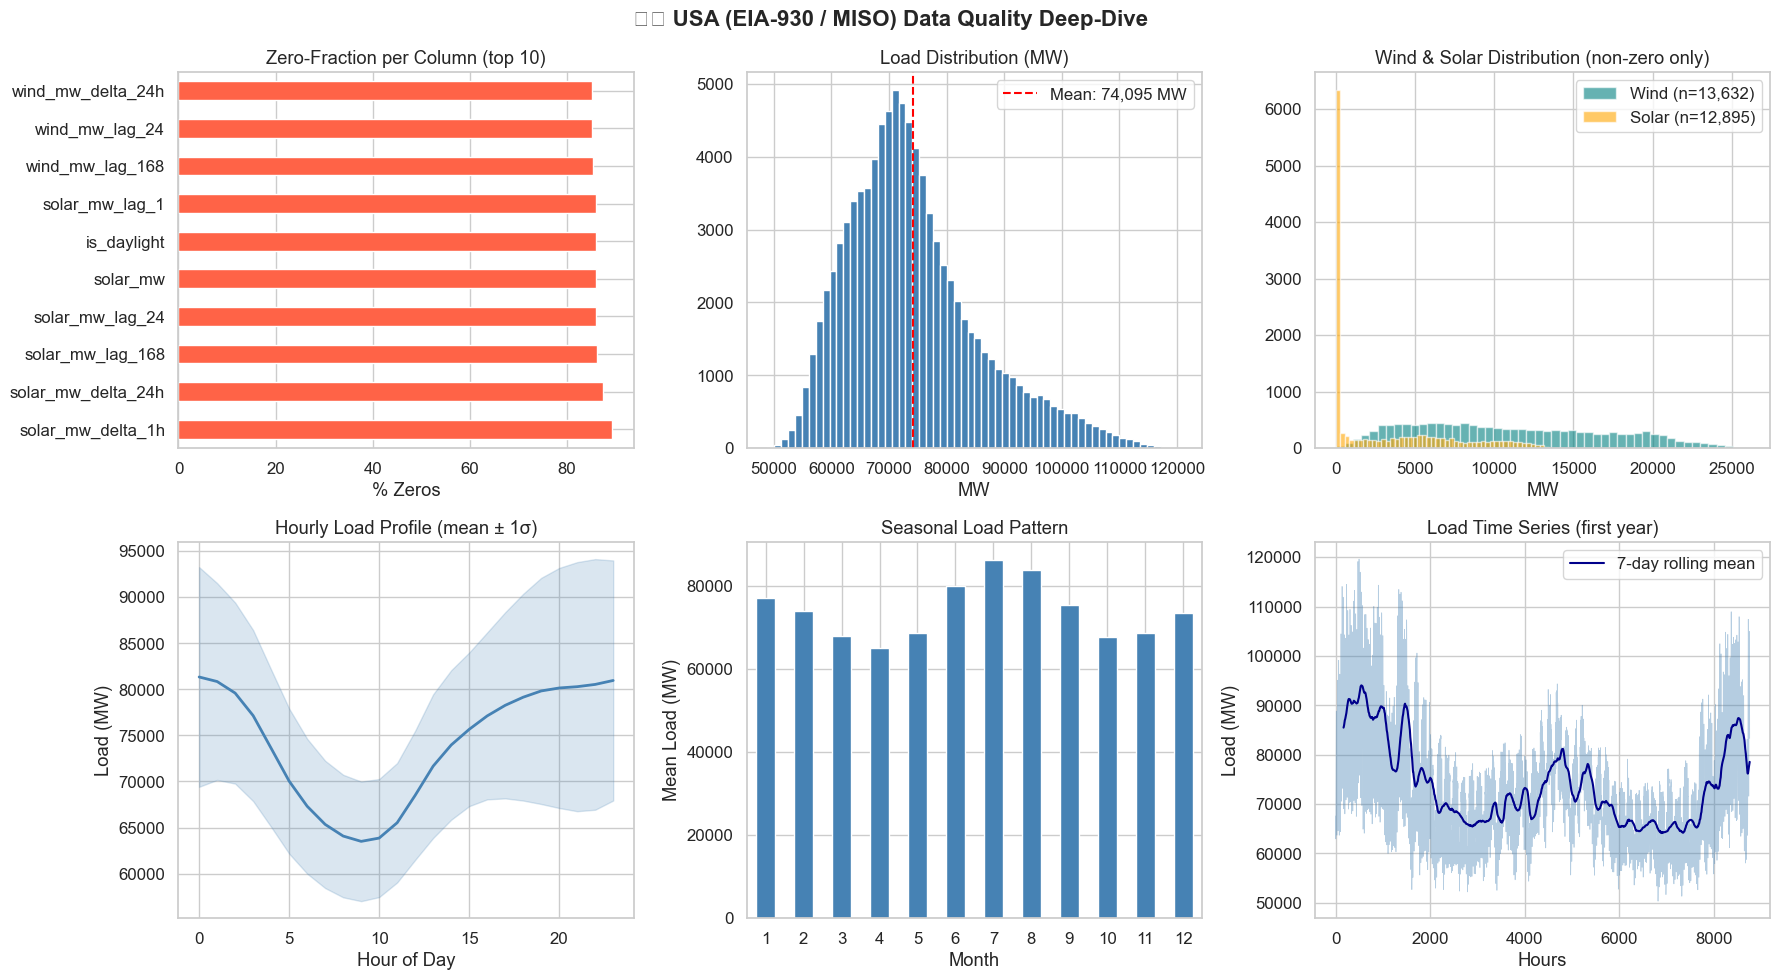

✅ Saved: reports/figures/usa_data_quality_deepdive.png


In [20]:
# ── USA Data Quality Deep-Dive ──
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("🇺🇸 USA (EIA-930 / MISO) Data Quality Deep-Dive", fontsize=16, fontweight="bold")

# 1. Zero-fraction per column (more informative than missing values)
ax = axes[0, 0]
zero_frac = ((df_us == 0).sum() / len(df_us) * 100).sort_values(ascending=False).head(10)
if len(zero_frac[zero_frac > 0]) > 0:
    zero_frac[zero_frac > 0].plot.barh(ax=ax, color="tomato")
else:
    ax.text(0.5, 0.5, "No zeros found", ha="center", va="center", transform=ax.transAxes)
ax.set_title("Zero-Fraction per Column (top 10)")
ax.set_xlabel("% Zeros")

# 2. Load distribution
ax = axes[0, 1]
if "load_mw" in df_us.columns:
    df_us["load_mw"].hist(bins=60, ax=ax, color="steelblue", edgecolor="white")
    ax.axvline(df_us["load_mw"].mean(), color="red", linestyle="--", label=f'Mean: {df_us["load_mw"].mean():,.0f} MW')
    ax.legend()
ax.set_title("Load Distribution (MW)")
ax.set_xlabel("MW")

# 3. Wind + Solar generation (non-zero)
ax = axes[0, 2]
for col, color, label in [("wind_mw", "teal", "Wind"), ("solar_mw", "orange", "Solar")]:
    if col in df_us.columns:
        vals = df_us[col]
        nonzero = vals[vals > 0]
        if len(nonzero) > 0:
            nonzero.hist(bins=50, ax=ax, alpha=0.6, color=color, edgecolor="white", label=f"{label} (n={len(nonzero):,})")
        else:
            ax.text(0.5, 0.5, f"{label}: ALL ZEROS", ha="center", va="center", transform=ax.transAxes, fontsize=12, color="red")
ax.set_title("Wind & Solar Distribution (non-zero only)")
ax.set_xlabel("MW")
ax.legend()

# 4. Hourly load profile
ax = axes[1, 0]
if "hour" in df_us.columns and "load_mw" in df_us.columns:
    hourly = df_us.groupby("hour")["load_mw"].agg(["mean", "std"])
    ax.fill_between(hourly.index, hourly["mean"] - hourly["std"], hourly["mean"] + hourly["std"], alpha=0.2, color="steelblue")
    ax.plot(hourly.index, hourly["mean"], color="steelblue", linewidth=2)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Load (MW)")
ax.set_title("Hourly Load Profile (mean ± 1σ)")

# 5. Monthly seasonality
ax = axes[1, 1]
if "month" in df_us.columns and "load_mw" in df_us.columns:
    monthly = df_us.groupby("month")["load_mw"].mean()
    monthly.plot.bar(ax=ax, color="steelblue", edgecolor="white")
    ax.set_xlabel("Month")
    ax.set_ylabel("Mean Load (MW)")
ax.set_title("Seasonal Load Pattern")
ax.tick_params(axis="x", rotation=0)

# 6. Time series overview (first year of load)
ax = axes[1, 2]
if "load_mw" in df_us.columns:
    n = min(8760, len(df_us))
    ax.plot(range(n), df_us["load_mw"].values[:n], alpha=0.4, color="steelblue", linewidth=0.5)
    rolling = df_us["load_mw"].rolling(168).mean()
    ax.plot(range(n), rolling.values[:n], color="darkblue", linewidth=1.5, label="7-day rolling mean")
    ax.legend()
    ax.set_xlabel("Hours")
    ax.set_ylabel("Load (MW)")
ax.set_title("Load Time Series (first year)")

plt.tight_layout()
fig.savefig(ROOT / "reports" / "figures" / "usa_data_quality_deepdive.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Saved: reports/figures/usa_data_quality_deepdive.png")

In [21]:
# ── USA vs Germany: Comprehensive Statistical Summary ──

def country_stats(df, name):
    """Generate detailed stats for a country's dataset."""
    stats = {
        "Country": name,
        "Rows": f"{len(df):,}",
        "Columns": len(df.columns),
        "Memory (MB)": f"{df.memory_usage(deep=True).sum() / 1e6:.1f}",
        "Date Range": f"{df.index.min()} → {df.index.max()}" if hasattr(df.index, 'min') else "N/A",
        "Missing Cells": f"{df.isnull().sum().sum():,}",
        "Missing %": f"{df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100:.2f}%",
    }
    
    # Target variables
    for target in ["load_mw", "wind_mw", "solar_mw"]:
        if target in df.columns:
            col = df[target]
            stats[f"{target} — mean"] = f"{col.mean():,.1f}"
            stats[f"{target} — std"]  = f"{col.std():,.1f}"
            stats[f"{target} — min"]  = f"{col.min():,.1f}"
            stats[f"{target} — max"]  = f"{col.max():,.1f}"
            stats[f"{target} — zeros%"] = f"{(col == 0).mean() * 100:.1f}%"
    
    return stats

stats_us = country_stats(df_us, "🇺🇸 USA (MISO)")
stats_de = country_stats(df_de, "🇩🇪 Germany (OPSD)")

comparison_df = pd.DataFrame([stats_de, stats_us]).set_index("Country").T
comparison_df.index.name = "Metric"

display(comparison_df.style
    .set_caption("Complete Statistical Comparison: Germany vs USA")
    .set_properties(**{"text-align": "right"}))

Country,🇩🇪 Germany (OPSD),🇺🇸 USA (MISO)
Metric,,
Rows,"17,377","92,382"
Columns,97,38
Memory (MB),13.4,27.7
Date Range,2018-10-07 23:00:00+00:00 → 2020-09-30 23:00:00+00:00,2015-07-08 06:00:00+00:00 → 2026-01-20 11:00:00+00:00
Missing Cells,0,0
Missing %,0.00%,0.00%
load_mw — mean,"55,156.4","74,095.3"
load_mw — std,"9,998.1","11,573.5"
load_mw — min,"31,923.0","48,878.0"


---

## Section 14 — Key Findings & Actionable Recommendations

### 🔍 Root Cause: Why USA Wind & Solar Are 85%+ Zeros

The `build_features_eia930.py` pipeline uses `usecols` that reference **new-format** column names
(e.g., `"Solar (Estimated Net Actual)"`, `"Wind (Estimated Net Actual)"`).

However, **legacy EIA-930 files (pre-2025H2)** use aggregate names like `"Solar"` and `"Wind"`
without the battery-storage split. When the pipeline reads these files, it gets **zeros** for wind/solar
because the exact column names don't match.

### 📋 Summary of Gaps

| Issue | Impact | Fix |
|-------|--------|-----|
| USA wind/solar 85%+ zeros | Degenerate GBM models (5.9 KB) | Fix `usecols` in `build_features_eia930.py` to handle legacy column names |
| USA parquet is stale (38 cols) | Missing price_usd_mwh, carbon_kg_per_mwh | Rebuild: `python -m src.gridpulse.data_pipeline.build_features_eia930` |
| 59 Germany-only features | Models not comparable | Weather features (Open-Meteo) + holidays needed for USA |
| `train_dl.yaml` hardcodes `price_eur_mwh` | Training crash on USA data | Use country-specific config or column mapping |
| Artifact paths not namespaced | Models can overwrite each other | Already split: `artifacts/models/` vs `artifacts/models_eia930/` |

### 🛠 Recommended Next Steps (Priority Order)

1. **Fix `build_features_eia930.py`** — Add column-name fallback for legacy CSV schema
2. **Rebuild USA parquet** — Run updated pipeline to get ~54 columns
3. **Add weather features** — Integrate Open-Meteo for a MISO-region city (e.g., Chicago)
4. **Retrain USA models** — Especially GBM solar/wind which are currently degenerate
5. **Add US holiday calendar** — `holidays` library supports US federal holidays
6. **Align training configs** — Make `train_dl.yaml` country-aware